In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
from collections import defaultdict
from config.config import Config
from src.data_loader import DataLoader
from src.pre_processing import PreProcessor
from src.feature_extraction import FeatureExtractor
from src.cache_manager import CacheManager
from src.models import ModelFactory

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
config = Config()

FEATURE_SET = "xgb" # baseline 46 features / xgb 100 features
RANDOM_STATE = config.RANDOM_STATE
NUM_FOLDS = config.NUM_FOLDS
SELECTED_MODELS = ["all"] # models we want to use for each run. all is for every model

In [3]:
loader = DataLoader()
preprocessor = PreProcessor()
feature_extractor = FeatureExtractor(feature_set=FEATURE_SET)
cache_manager = CacheManager()
factory = ModelFactory()
#cache_manager.clear_cache() # clear cached features to extract again

if SELECTED_MODELS[0] == "all":
        SELECTED_MODELS = list(factory.get_all_models().keys())
metadata = loader.load_metadata()

In [4]:
def extract_X_Y(df, feature_set):
    X, Y = [], []

    for _, row in df.iterrows():
        audio_path = loader.get_audio_path(row["slice_file_name"], row["fold"])

        feats = cache_manager.load_cached_features(audio_path, feature_set)
        if feats is None:
            audio, sr = preprocessor.load_and_preprocess(audio_path)
            feats = feature_extractor.extract_features(audio, sr)
            cache_manager.save_cached_features(audio_path, feature_set, feats)

        X.append(feats)
        Y.append(row["classID"])

    return np.array(X), np.array(Y)

In [5]:
# Store metrics per model per fold
all_fold_metrics = defaultdict(lambda: {"accuracy": [], "precision": [], "recall": [], "f1": []})

for test_fold in range(1, NUM_FOLDS + 1):
    train_df = metadata[metadata["fold"] != test_fold].copy()
    test_df = metadata[metadata["fold"] == test_fold].copy()

    print(f"\n--- Fold {test_fold} (test) ---")
    print(f"Train: {len(train_df)}, Test: {len(test_df)}")

    X_train, Y_train = extract_X_Y(train_df, FEATURE_SET)
    X_test, Y_test = extract_X_Y(test_df, FEATURE_SET)
    print(f"Feature dimension: {X_train.shape[1]}")

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    for model_name in SELECTED_MODELS:
        print(f"\n--- {model_name} ---\n")
        model = factory.get_model(model_name)
        model.fit(X_train_s, Y_train)
        Y_pred = model.predict(X_test_s)

        acc = accuracy_score(Y_test, Y_pred)
        prec = precision_score(Y_test, Y_pred, average="weighted", zero_division=0)
        rec = recall_score(Y_test, Y_pred, average="weighted", zero_division=0)
        f1 = f1_score(Y_test, Y_pred, average="weighted", zero_division=0)

        all_fold_metrics[model_name]["accuracy"].append(acc)
        all_fold_metrics[model_name]["precision"].append(prec)
        all_fold_metrics[model_name]["recall"].append(rec)
        all_fold_metrics[model_name]["f1"].append(f1)

        print(f"  {model_name}: acc={acc:.4f}")

print("\n10-fold CV complete.")


--- Fold 1 (test) ---
Train: 7859, Test: 873
Feature dimension: 100

--- svm ---

  svm: acc=0.6655

--- random_forest ---

  random_forest: acc=0.7216

--- logistic_regression ---

  logistic_regression: acc=0.6884

--- xgboost ---

  xgboost: acc=0.6747

--- mlp ---

  mlp: acc=0.6105

--- Fold 2 (test) ---
Train: 7844, Test: 888
Feature dimension: 100

--- svm ---

  svm: acc=0.6655

--- random_forest ---

  random_forest: acc=0.6340

--- logistic_regression ---

  logistic_regression: acc=0.6239

--- xgboost ---

  xgboost: acc=0.6318

--- mlp ---

  mlp: acc=0.6757

--- Fold 3 (test) ---
Train: 7807, Test: 925
Feature dimension: 100

--- svm ---

  svm: acc=0.6249

--- random_forest ---

  random_forest: acc=0.6519

--- logistic_regression ---

  logistic_regression: acc=0.6400

--- xgboost ---

  xgboost: acc=0.6259

--- mlp ---

  mlp: acc=0.6184

--- Fold 4 (test) ---
Train: 7742, Test: 990
Feature dimension: 100

--- svm ---

  svm: acc=0.6667

--- random_forest ---

  random

In [6]:
results = {}
for model_name in SELECTED_MODELS:
    results[model_name] = {
        "accuracy": np.mean(all_fold_metrics[model_name]["accuracy"]),
        "accuracy_std": np.std(all_fold_metrics[model_name]["accuracy"]),
        "precision": np.mean(all_fold_metrics[model_name]["precision"]),
        "precision_std": np.std(all_fold_metrics[model_name]["precision"]),
        "recall": np.mean(all_fold_metrics[model_name]["recall"]),
        "recall_std": np.std(all_fold_metrics[model_name]["recall"]),
        "f1": np.mean(all_fold_metrics[model_name]["f1"]),
        "f1_std": np.std(all_fold_metrics[model_name]["f1"]),
    }
    print(f"{model_name}:")
    print(f"  Accuracy : {results[model_name]['accuracy']:.4f} ± {results[model_name]['accuracy_std']:.4f}")
    print(f"  Precision: {results[model_name]['precision']:.4f} ± {results[model_name]['precision_std']:.4f}")
    print(f"  Recall   : {results[model_name]['recall']:.4f} ± {results[model_name]['recall_std']:.4f}")
    print(f"  F1-Score : {results[model_name]['f1']:.4f} ± {results[model_name]['f1_std']:.4f}")
    print()

svm:
  Accuracy : 0.6840 ± 0.0374
  Precision: 0.6809 ± 0.0451
  Recall   : 0.6840 ± 0.0374
  F1-Score : 0.6749 ± 0.0418

random_forest:
  Accuracy : 0.6815 ± 0.0305
  Precision: 0.6947 ± 0.0357
  Recall   : 0.6815 ± 0.0305
  F1-Score : 0.6752 ± 0.0321

logistic_regression:
  Accuracy : 0.6766 ± 0.0418
  Precision: 0.6798 ± 0.0473
  Recall   : 0.6766 ± 0.0418
  F1-Score : 0.6733 ± 0.0456

xgboost:
  Accuracy : 0.7040 ± 0.0494
  Precision: 0.7064 ± 0.0614
  Recall   : 0.7040 ± 0.0494
  F1-Score : 0.6954 ± 0.0557

mlp:
  Accuracy : 0.6883 ± 0.0474
  Precision: 0.6857 ± 0.0559
  Recall   : 0.6883 ± 0.0474
  F1-Score : 0.6783 ± 0.0518



In [7]:
summary_data = []
for model_name in SELECTED_MODELS:
    summary_data.append({
        "Model": model_name,
        "Accuracy": f"{results[model_name]['accuracy']:.4f} ± {results[model_name]['accuracy_std']:.4f}",
        "Precision": f"{results[model_name]['precision']:.4f} ± {results[model_name]['precision_std']:.4f}",
        "Recall": f"{results[model_name]['recall']:.4f} ± {results[model_name]['recall_std']:.4f}",
        "F1-Score": f"{results[model_name]['f1']:.4f} ± {results[model_name]['f1_std']:.4f}",
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Model", key=lambda c: summary_df.index.map(lambda i: results[SELECTED_MODELS[i]]["accuracy"]), ascending=False)
summary_df

,Model,Accuracy,Precision,Recall,F1-Score
3,xgboost,0.7040 ± 0.0494,0.7064 ± 0.0614,0.7040 ± 0.0494,0.6954 ± 0.0557
4,mlp,0.6883 ± 0.0474,0.6857 ± 0.0559,0.6883 ± 0.0474,0.6783 ± 0.0518
0,svm,0.6840 ± 0.0374,0.6809 ± 0.0451,0.6840 ± 0.0374,0.6749 ± 0.0418
1,random_forest,0.6815 ± 0.0305,0.6947 ± 0.0357,0.6815 ± 0.0305,0.6752 ± 0.0321
2,logistic_regression,0.6766 ± 0.0418,0.6798 ± 0.0473,0.6766 ± 0.0418,0.6733 ± 0.0456


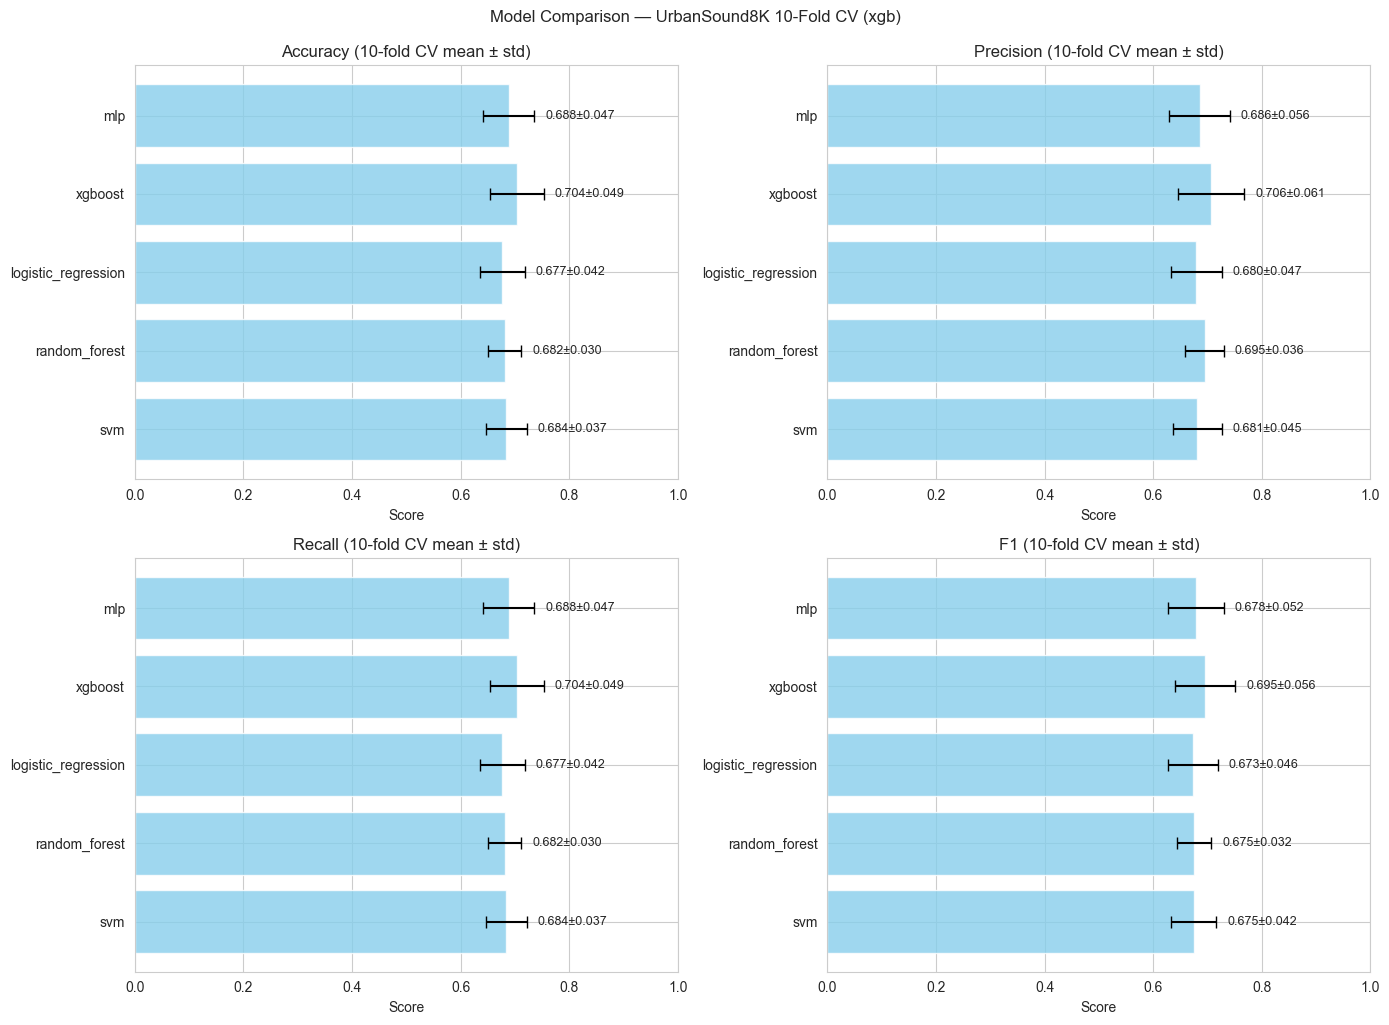

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["accuracy", "precision", "recall", "f1"]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    model_names = list(results.keys())
    means = [results[m][metric] for m in model_names]
    stds = [results[m][f"{metric}_std"] for m in model_names]
    x = range(len(model_names))
    bars = ax.barh(x, means, xerr=stds, capsize=4, color="skyblue", alpha=0.8)
    ax.set_yticks(x)
    ax.set_yticklabels(model_names)
    ax.set_xlabel("Score")
    ax.set_title(f"{metric.capitalize()} (10-fold CV mean ± std)")
    ax.set_xlim([0, 1])
    for i, (m, s) in enumerate(zip(means, stds)):
        ax.text(m + s + 0.02, i, f"{m:.3f}±{s:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.suptitle(f"Model Comparison — UrbanSound8K 10-Fold CV ({FEATURE_SET})", y=1.02)
plt.show()